# 목표 : 특정 시간을 기준으로 기간 매출 예측
- 기준시 : 2018-05-12 15:05
- 2018-05-06 - 2018-05-13. (주) 매출 예측
- 2018-05-01 - 2018-05-31 (월) 매출 예측
- 2018-04-01 - 2018-06-30 (분기) 매출 예측

## 1. import

In [1]:
import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib

from tqdm.auto import tqdm
from sklearn.utils import shuffle

from sklearn.preprocessing import LabelEncoder
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import Normalizer, RobustScaler
from sklearn.ensemble import *
from sklearn.tree import *
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

## 2. 데이터 불러오기

In [2]:
original_df = pd.read_csv('olist_total.csv')
original_df

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,...,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,seller_geolocation_lat,seller_geolocation_lng,product_category_name_english
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,...,650.00,28.00,9.00,14.00,27277,volta redonda,SP,-22.50,-44.13,cool_stuff
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.90,17.96,e6eecc5a77de221464d1c4eaff0a9b64,delivered,2017-06-28 11:52:20,...,650.00,28.00,9.00,14.00,27277,volta redonda,SP,-22.50,-44.13,cool_stuff
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.90,18.33,4ef55bf80f711b372afebcb7c715344a,delivered,2018-05-18 10:25:53,...,650.00,28.00,9.00,14.00,27277,volta redonda,SP,-22.50,-44.13,cool_stuff
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.90,16.17,30407a72ad8b3f4df4d15369126b20c9,delivered,2017-08-01 18:38:42,...,650.00,28.00,9.00,14.00,27277,volta redonda,SP,-22.50,-44.13,cool_stuff
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.90,13.29,91a792fef70ecd8cc69d3c7feb3d12da,delivered,2017-08-10 21:48:40,...,650.00,28.00,9.00,14.00,27277,volta redonda,SP,-22.50,-44.13,cool_stuff
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115032,2c12150c742ae2fa48bc703964c16c5f,1,2b54fb9a4acf707537eb53eb2458c241,ef728fa1f17436c91ed1ccd03dcf9631,2018-08-02 17:50:12,57.90,19.60,ab0cf72dfe0538a63a57d6905ccb7b57,delivered,2018-07-28 17:55:27,...,1000.00,25.00,25.00,25.00,17201,jau,SP,-22.29,-48.56,arts_and_craftmanship
115033,2ef4a11b6e24fdfbb43b92cb5f95edff,1,9c313adb4b38a55b092f53f83f78be9e,ef728fa1f17436c91ed1ccd03dcf9631,2018-07-30 09:17:39,19.00,12.86,ee1cfdc92e449920e25d3ca4ab4da4f6,delivered,2018-07-23 18:35:14,...,500.00,16.00,6.00,16.00,17201,jau,SP,-22.29,-48.56,arts_and_craftmanship
115034,2ef4a11b6e24fdfbb43b92cb5f95edff,2,eacb104882d39ffb53140b1d1860a7c3,ef728fa1f17436c91ed1ccd03dcf9631,2018-07-30 09:17:39,39.90,12.87,ee1cfdc92e449920e25d3ca4ab4da4f6,delivered,2018-07-23 18:35:14,...,500.00,21.00,7.00,14.00,17201,jau,SP,-22.29,-48.56,arts_and_craftmanship
115035,9f7ba492c273ffac8f90a623b8eadd3b,1,5aa0d6ed4e6c0995d62090cd82cde89a,ef728fa1f17436c91ed1ccd03dcf9631,2018-08-28 03:24:24,11.90,12.79,c61336d6c835632048f973d2f2db598d,delivered,2018-08-23 12:31:37,...,200.00,16.00,6.00,16.00,17201,jau,SP,-22.29,-48.56,arts_and_craftmanship


In [3]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115037 entries, 0 to 115036
Data columns (total 44 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       115037 non-null  object 
 1   order_item_id                  115037 non-null  int64  
 2   product_id                     115037 non-null  object 
 3   seller_id                      115037 non-null  object 
 4   shipping_limit_date            115037 non-null  object 
 5   price                          115037 non-null  float64
 6   freight_value                  115037 non-null  float64
 7   customer_id                    115037 non-null  object 
 8   order_status                   115037 non-null  object 
 9   order_purchase_timestamp       115037 non-null  object 
 10  order_approved_at              115023 non-null  object 
 11  order_delivered_carrier_date   113852 non-null  object 
 12  order_delivered_customer_date 

## 3. 데이터 전처리

In [4]:
df = original_df.copy()

In [5]:
# 1) 날짜 관련 컬럼 object → datetime 으로 변경

df.shipping_limit_date = pd.to_datetime(df.shipping_limit_date)
df.order_purchase_timestamp = pd.to_datetime(df.order_purchase_timestamp)

df.order_approved_at = pd.to_datetime(df.order_approved_at)
df.order_delivered_carrier_date = pd.to_datetime(df.order_delivered_carrier_date)
df.order_delivered_customer_date = pd.to_datetime(df.order_delivered_customer_date)
df.order_estimated_delivery_date = pd.to_datetime(df.order_estimated_delivery_date)

df.review_creation_date = pd.to_datetime(df.review_creation_date)
df.review_answer_timestamp = pd.to_datetime(df.review_answer_timestamp)

In [6]:
# 2) id 관련 컬럼 int → object 로 변경

df.order_item_id = df.order_item_id.astype('object')

In [7]:
# 3) object 타입 컬럼 범주형(LabelEncoder) 으로 변경

# payment_type
le_payment = LabelEncoder()
df['payment_type'] = le_payment.fit_transform(df.payment_type)
# df['payment_type'].unique(), le_payment.classes_

# customer_city
le_city = LabelEncoder()
df['customer_city'] = le_city.fit_transform(df.customer_city)
# df['customer_city'].unique(), le_city.classes_

# seller_city
le_city2 = LabelEncoder()
df['seller_city'] = le_city2.fit_transform(df.seller_city)
# df['seller_city'].unique(), le_city2.classes_

# customer_state
le_state = LabelEncoder()
df['customer_state'] = le_state.fit_transform(df.customer_state)
# df['customer_state'].unique(), le_state.classes_

# seller_state (le_state 동시 사용)
df['seller_state'] = le_state.transform(df.seller_state)
# df['seller_state'].unique(), le_state.classes_

# product_category_name_english
le_category = LabelEncoder()
df['product_category_name_english'] = le_category.fit_transform(df.product_category_name_english)
# df['product_category_name_english'].unique(), le_category.classes_

In [8]:
# 4) 년, 월, 분기, 일, 시간 컬럼 생성

df['order_purchase_year'] = [y.year for y in df.order_purchase_timestamp]
df['order_purchase_month'] = [y.month for y in df.order_purchase_timestamp]
df['order_purchase_quarter'] = [y.quarter for y in df.order_purchase_timestamp]
df['order_purchase_day'] = [y.day for y in df.order_purchase_timestamp]
df['order_purchase_hour'] = [y.hour for y in df.order_purchase_timestamp]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115037 entries, 0 to 115036
Data columns (total 49 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115037 non-null  object        
 1   order_item_id                  115037 non-null  object        
 2   product_id                     115037 non-null  object        
 3   seller_id                      115037 non-null  object        
 4   shipping_limit_date            115037 non-null  datetime64[ns]
 5   price                          115037 non-null  float64       
 6   freight_value                  115037 non-null  float64       
 7   customer_id                    115037 non-null  object        
 8   order_status                   115037 non-null  object        
 9   order_purchase_timestamp       115037 non-null  datetime64[ns]
 10  order_approved_at              115023 non-null  datetime64[ns]
 11  

## 4. 데이터 관계 파악

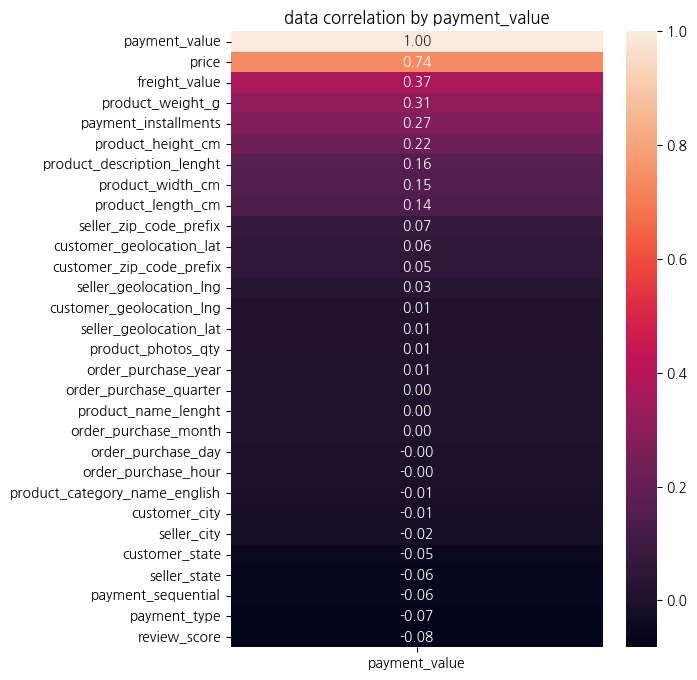

In [10]:
f, ax = plt.subplots(figsize=(6, 8))
sns.heatmap(pd.DataFrame(df.corr().payment_value).sort_values(['payment_value'], ascending=False), annot=True, fmt=".2f")
plt.title('data correlation by payment_value');

## 5. 데이터 변수 선정

- 시간관련 컬럼, 카테고리 컬럼, 결제값 컬럼(목표변수)



- order_purchase_timestamp
- order_purchase_year
- order_purchase_month
- order_purchase_quarter
- order_purchase_day
- product_category_name_english
- payment_value (*target)

In [11]:
df = df[['order_purchase_timestamp', 'order_purchase_year', 'order_purchase_month', 'order_purchase_quarter', 'order_purchase_day', 'product_category_name_english', 'payment_value']]
df

,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_quarter,order_purchase_day,product_category_name_english,payment_value
0,2017-09-13 08:59:02,2017,9,3,13,20,72.19
1,2017-06-28 11:52:20,2017,6,2,28,20,73.86
2,2018-05-18 10:25:53,2018,5,2,18,20,83.23
3,2017-08-01 18:38:42,2017,8,3,1,20,75.07
4,2017-08-10 21:48:40,2017,8,3,10,20,72.19
...,...,...,...,...,...,...,...
115032,2018-07-28 17:55:27,2018,7,3,28,3,77.50
115033,2018-07-23 18:35:14,2018,7,3,23,3,84.63
115034,2018-07-23 18:35:14,2018,7,3,23,3,84.63
115035,2018-08-23 12:31:37,2018,8,3,23,3,24.69


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115037 entries, 0 to 115036
Data columns (total 7 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_purchase_timestamp       115037 non-null  datetime64[ns]
 1   order_purchase_year            115037 non-null  int64         
 2   order_purchase_month           115037 non-null  int64         
 3   order_purchase_quarter         115037 non-null  int64         
 4   order_purchase_day             115037 non-null  int64         
 5   product_category_name_english  115037 non-null  int32         
 6   payment_value                  115037 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int32(1), int64(4)
memory usage: 5.7 MB


## 6. 회귀 모델 선정

In [13]:
X = df.iloc[:,1:-1]
y = df.payment_value

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=128)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

reg = LazyRegressor(verbose=0, predictions=True)

models, predictions = reg.fit(x_train, x_test, y_train, y_test)
models

(92029, 5) (23008, 5) (92029,) (23008,)


 95%|███████████████████████████████████████████████████████████████████████████▏   | 40/42 [1:00:30<05:11, 155.95s/it]

[02:20:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


100%|████████████████████████████████████████████████████████████████████████████████| 42/42 [1:00:35<00:00, 86.57s/it]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
RandomForestRegressor,0.38,0.38,214.42,21.90
BaggingRegressor,0.36,0.36,218.57,2.14
ExtraTreesRegressor,0.35,0.35,219.31,13.42
ExtraTreeRegressor,0.33,0.33,222.47,0.19
KNeighborsRegressor,0.33,0.33,223.84,0.80
DecisionTreeRegressor,0.32,0.32,224.23,0.30
LGBMRegressor,0.29,0.29,229.86,0.76
HistGradientBoostingRegressor,0.26,0.26,234.03,1.47
GradientBoostingRegressor,0.08,0.08,260.93,6.16


## 7. 특정 날짜를 기준으로 데이터 셋 분리

In [14]:
import datetime

today = pd.to_datetime('2018-5-12')
print(today)

def cut_date(today):
    if today.quarter==1:
        return today.year-1, 12, 31
    elif today.quarter==2:
        return today.year, 3, 31
    elif today.quarter==3:
        return today.year, 6, 30
    else:
        return today.year, 9, 30

b_year, b_month, b_day = cut_date(today)
before_date = pd.to_datetime(str(b_year) + '-' + str(b_month) + '-' + str(b_day))

before_df = df[df.order_purchase_timestamp < before_date]
before_df

2018-05-12 00:00:00


,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_quarter,order_purchase_day,product_category_name_english,payment_value
0,2017-09-13 08:59:02,2017,9,3,13,20,72.19
1,2017-06-28 11:52:20,2017,6,2,28,20,73.86
3,2017-08-01 18:38:42,2017,8,3,1,20,75.07
4,2017-08-10 21:48:40,2017,8,3,10,20,72.19
5,2017-07-27 15:11:51,2017,7,3,27,20,82.83
...,...,...,...,...,...,...,...
115007,2018-01-17 10:43:45,2018,1,1,17,35,66.90
115008,2018-01-18 16:33:51,2018,1,1,18,35,36.70
115011,2017-11-15 19:08:22,2017,11,4,15,35,31.90
115015,2017-05-08 12:01:54,2017,5,2,8,3,73.07


In [15]:
# train, test 데이터 셋 나누기

X = before_df.iloc[:,1:-1]
y = before_df.payment_value

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=128)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

robust = RobustScaler()
x_train_robust = robust.fit_transform(x_train)
x_test_robust = robust.transform(x_test)

(61432, 5) (15359, 5) (61432,) (15359,)


## 8. 모델 학습(테스트)
- gridSearchCV를 이용한 최적의 모델 및 하이퍼파라미터 선정
    - RandomForestRegressor
    - ExtraTreesRegressor

#### RandomForestRegressor 적용

In [16]:
# 학습 - RandomForestRegressor.ver

params = {
    'max_depth' : [6, 8, 10],
    'n_estimators' : [50, 100, 200],    # decisiontree 몇개 쓸지 정하는 파라미터
    'min_samples_leaf' : [8, 12],       # 마지막 잎에 담을 최소 데이터
    'min_samples_split' : [8, 12]       # 마지막 분기의 최소 데이터
}

rfr = RandomForestRegressor(random_state=13, n_jobs=-1)     # cpu core 사용 개수 설정(-1 : 모두 사용)
grid_cv = GridSearchCV(rfr, param_grid=params, cv=5, n_jobs=-1)
grid_cv.fit(x_train_robust, y_train)

y_pred = grid_cv.best_estimator_.predict(x_test_robust)

print('mse : ', mean_squared_error(y_test, y_pred))
print('rmse : ', sqrt(mean_squared_error(y_test, y_pred)))
print('rmsle : ', sqrt(mean_squared_error(np.log1p(y_test), np.log1p(y_pred))))
print('r2 : ', r2_score(y_test, y_pred))

randomforest_result = pd.DataFrame(columns=['실제값', '예측값'])
randomforest_result['실제값'] = y_test.round()
randomforest_result['예측값'] = y_pred.round()
randomforest_result

mse :  50330.40425859139
rmse :  224.34438762445427
rmsle :  0.9758309592294878
r2 :  0.20896212365488764


,실제값,예측값
56873,53.00,158.00
96678,120.00,251.00
33461,275.00,143.00
5786,108.00,126.00
23401,45.00,164.00
...,...,...
62482,15.00,162.00
67550,53.00,96.00
75058,55.00,166.00
96904,1233.00,205.00


In [17]:
grid_cv.best_estimator_

RandomForestRegressor(max_depth=10, min_samples_leaf=8, min_samples_split=8,
                      n_jobs=-1, random_state=13)

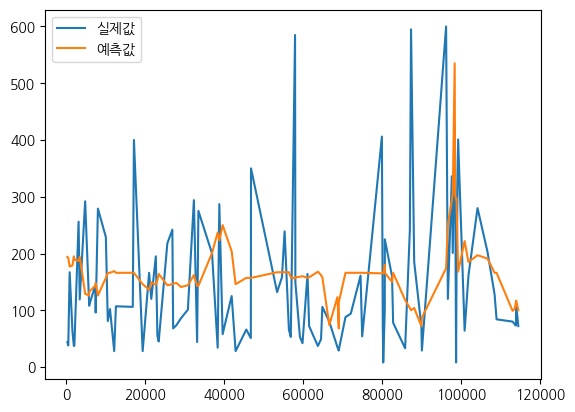

In [18]:
randomforest_result[:100].sort_index().plot();

#### ExtraTreesRegressor 적용

In [19]:
# 학습 - ExtraTreesRegressor.ver

params = {
    'n_estimators' : [50, 70, 90, 110, 130, 150],
    'min_samples_split' : [1, 2, 3]
}

etr = ExtraTreesRegressor()
etr.fit(x_train_robust, y_train)
y_pred = etr.predict(x_test_robust)

grid_cv = GridSearchCV(etr, param_grid=params, cv=5, n_jobs=-1)
grid_cv.fit(x_train_robust, y_train)

y_pred = grid_cv.best_estimator_.predict(x_test_robust)

print('mse : ', mean_squared_error(y_test, y_pred))
print('rmse : ', sqrt(mean_squared_error(y_test, y_pred)))
print('rmsle : ', sqrt(mean_squared_error(np.log1p(y_test), np.log1p(y_pred))))
print('r2 : ', r2_score(y_test, y_pred))

extratrees_result = pd.DataFrame(columns=['실제값', '예측값'])
extratrees_result['실제값'] = y_test.round()
extratrees_result['예측값'] = y_pred.round()
extratrees_result

mse :  42794.09201811954
rmse :  206.86732950884135
rmsle :  0.950451715115136
r2 :  0.327409581369454


,실제값,예측값
56873,53.00,169.00
96678,120.00,81.00
33461,275.00,126.00
5786,108.00,97.00
23401,45.00,154.00
...,...,...
62482,15.00,52.00
67550,53.00,60.00
75058,55.00,126.00
96904,1233.00,126.00


In [20]:
grid_cv.best_estimator_

ExtraTreesRegressor(min_samples_split=3, n_estimators=150)

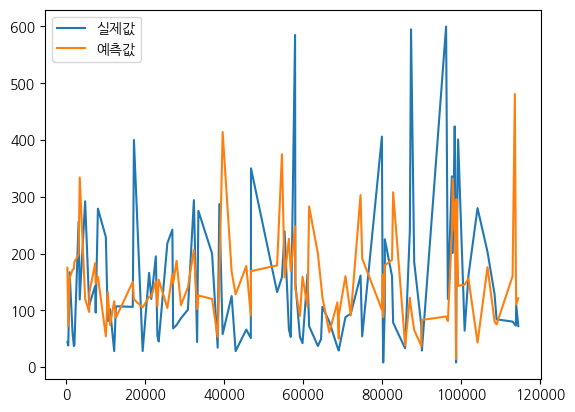

In [21]:
extratrees_result[:100].sort_index().plot();

## 9. 최종 선정 모델 및 실행 코드
- 목표 : 특정 카테고리를 이용한 매출 예측
- 모델 : ExtraTreesRegressor(min_samples_split=3, n_estimators=150)

In [22]:
# 카테고리 labelencoder 결과 원본 출력
def get_categories(df):
    
    top10_category_num = df.product_category_name_english.value_counts()[:10].index.to_list()
    top10_category = le_category.inverse_transform(top10_category_num)
    top10_category_num, top10_category
    
    top10_categories = pd.DataFrame()
    top10_categories['top10_category_num'] = top10_category_num
    top10_categories['top10_category'] = top10_category
    
    return top10_categories

In [23]:
# 분기를 이용한 예측 날짜 생성 함수
def get_month_by_quarter(month):
    if math.ceil(month/3)==1:
        return 1, 3
    elif math.ceil(month/3)==2:
        return 4, 6
    elif math.ceil(month/3)==3:
        return 7, 9
    else:
        return 10, 12

In [24]:
# train, test 데이터 셋 나누기
def train_test(df):
    X = df.iloc[:,1:-1]
    y = df.payment_value

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=128)

    robust = RobustScaler()
    x_train_robust = robust.fit_transform(x_train)
    x_test_robust = robust.transform(x_test)
    
    return x_train_robust, x_test_robust, y_train, y_test, robust

In [25]:
def get_future_df(year, start_month, end_month):
    date = []
    for m in range(start_month, end_month+1):
        for d in range(1, 32):
            try:
                date.append(datetime.date(year, m, d))
            except:
                pass

    # 오늘 날짜 기준 예측 데이터 프레임 생성
    category = [i for i in range(0, 71)]
    
    future_df = pd.DataFrame()
    future_df['order_purchase_date'] = date * len(category)
    future_df['order_purchase_year'] = [row.year for row in future_df.order_purchase_date]
    future_df['order_purchase_month'] = [row.month for row in future_df.order_purchase_date]
    future_df['order_purchase_quarter'] = [math.ceil(row.month/3) for row in future_df.order_purchase_date]
    future_df['order_purchase_day'] = [row.day for row in future_df.order_purchase_date]
    future_df['product_category_name_english'] = category * len(date)

    return future_df

In [26]:
def show_graph(df, title_):
    df.plot()
    plt.title(title_)
    plt.xticks(rotation=45)
    plt.show()

Date(ex.2018-1-1) : 2018-5-12


,product_category_name_english,payment_value,pred_value
order_purchase_date,,,
2018-04-01,4,181.62,307.90
2018-04-01,5,2530.99,2201.90
2018-04-01,6,1639.29,1180.93
2018-04-01,7,3809.02,1969.90
2018-04-01,8,170.96,62.12
...,...,...,...
2018-06-30,63,979.45,185.32
2018-06-30,65,1881.54,2136.40
2018-06-30,68,332.96,110.22


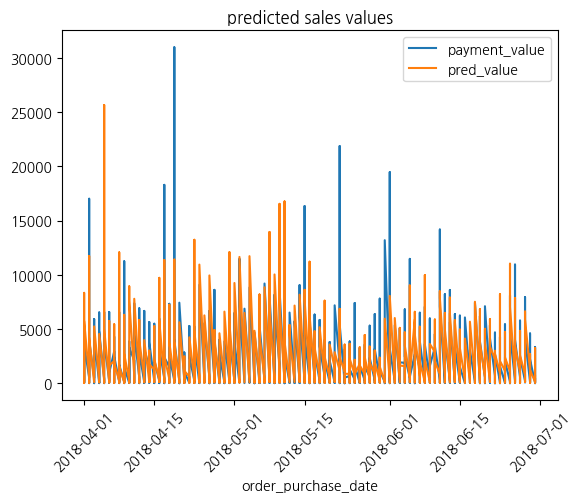

In [27]:
import datetime

# 기준 날짜 입력받기
input_date = datetime.datetime.strptime(input('Date(ex.2018-1-1) : '), '%Y-%m-%d')
year, month, day = input_date.year, input_date.month, input_date.day

# 기준 날짜 이전 데이터 셋 나누기
b_year, b_month, b_day = cut_date(today)
before_date = pd.to_datetime(str(b_year) + '-' + str(b_month) + '-' + str(b_day))
before_df = df[df.order_purchase_timestamp < before_date]
x_train, x_test, y_train, y_test, robust = train_test(before_df)

# 예측 시작날짜, 종료날짜 선언 및 데이터프레임 생성
start_month, end_month = get_month_by_quarter(month)
future_df = get_future_df(year, start_month, end_month)

# 학습 및 예측
etr = ExtraTreesRegressor(min_samples_split=3, n_estimators=150)
etr.fit(x_train, y_train)
future_df['pred_value'] = etr.predict(robust.transform(future_df.iloc[:,1:]))

# 실제값과 예측값 비교 데이터프레임 생성
future_result = pd.merge(future_df, df, on=['order_purchase_year', 'order_purchase_month', 'order_purchase_quarter', 'order_purchase_day', 'product_category_name_english'])
# future_result = future_result.pivot_table(index=['order_purchase_date', 'order_purchase_year', 'order_purchase_month', 'order_purchase_quarter', 'order_purchase_day', 'product_category_name_english'], values=['pred_value', 'payment_value']).reset_index()
future_result = future_result.pivot_table(index=['order_purchase_date', 'product_category_name_english'], values=['pred_value', 'payment_value'], aggfunc='sum').reset_index()
future_result = future_result.set_index('order_purchase_date')
display(future_result)

# 해당기간 전체 매출 예측 그래프
show_graph(future_result[['payment_value', 'pred_value']], 'predicted sales values')

,top10_category_num,top10_category
0,7,bed_bath_table
1,65,sports_leisure
2,39,furniture_decor
3,43,health_beauty
4,15,computers_accessories
5,49,housewares
6,70,watches_gifts
7,42,garden_tools
8,68,telephony
9,69,toys


Category Number : 7


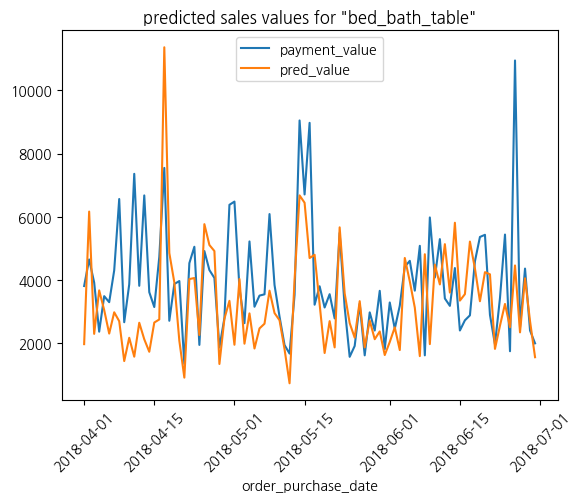

Category Number : 43


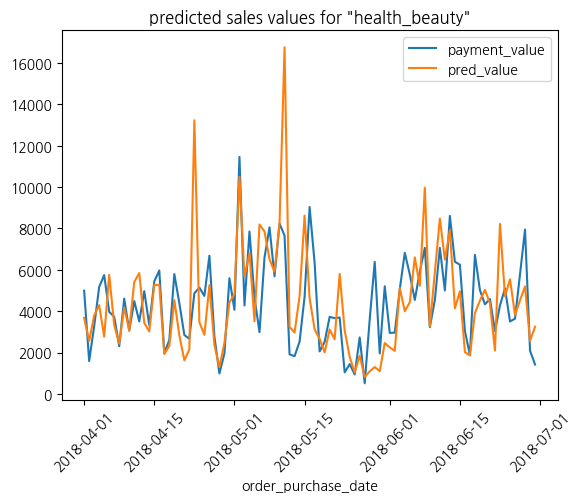

Category Number : 68


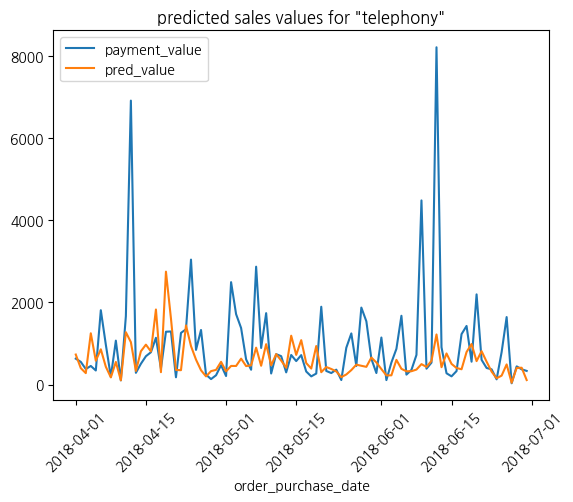

Category Number : 49


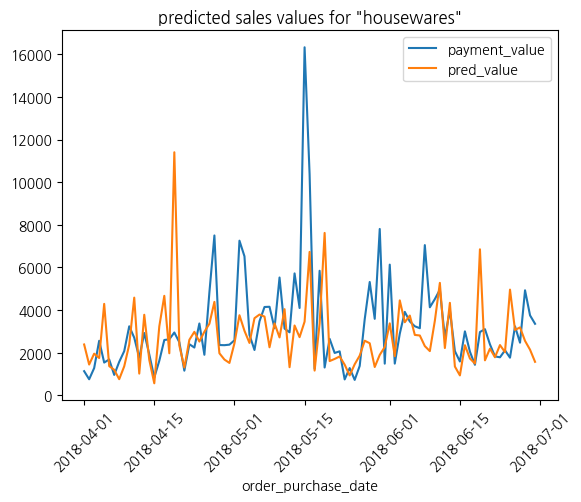

Category Number : d
Invalid input type


In [28]:
# 기준 날짜 top10 category 출력 및 category 입력받기
top10_categories = get_categories(before_df)
display(top10_categories)

while(1):
    try:
        input_category = int(input('Category Number : '))
    except:
        print('Invalid input type')
        break
    
    if (input_category not in top10_categories.top10_category_num.to_list()):
        print('Invalid input number')
        break
    
    # 해당기간 특정 카테고리 매출 예측 그래프
    category_pred_df = future_result[future_result.product_category_name_english==input_category]
    category_name = top10_categories[top10_categories.top10_category_num==input_category].top10_category.values
    show_graph(category_pred_df[['payment_value', 'pred_value']], f'predicted sales values for "{category_name[0]}"')

## 10. 주별, 월별, 분기별 매출 예측값 확인

In [29]:
def get_weekday(day):
    weekday = day.isoweekday()

    if weekday==1: # 월
        return day-pd.Timedelta(1, 'D'), day+pd.Timedelta(6, 'D')
    elif weekday==2:
        return day-pd.Timedelta(2, 'D'), day+pd.Timedelta(5, 'D')
    elif weekday==3:
        return day-pd.Timedelta(3, 'D'), day+pd.Timedelta(4, 'D')
    elif weekday==4:
        return day-pd.Timedelta(4, 'D'), day+pd.Timedelta(3, 'D')
    elif weekday==5:
        return day-pd.Timedelta(5, 'D'), day+pd.Timedelta(2, 'D')
    elif weekday==6:
        return day-pd.Timedelta(6, 'D'), day+pd.Timedelta(1, 'D')
    elif weekday==7:
        return day, day+pd.Timedelta(6, 'D')

start, end = get_weekday(input_date)
start, end

(datetime.datetime(2018, 5, 6, 0, 0), datetime.datetime(2018, 5, 13, 0, 0))

In [30]:
# 주, 월 기간 산출을 위한 컬럼 생성
future_result.reset_index(inplace=True)
future_result['order_purchase_month'] = [row.month for row in future_result.order_purchase_date]
future_result['order_purchase_day'] = [row.day for row in future_result.order_purchase_date]


# 주 매출 예측
dur_week = future_result[(future_result.order_purchase_date>=start.date())&(future_result.order_purchase_date<=end.date())]
pred_week = int(dur_week.pred_value.sum())
actual_week = int(dur_week.payment_value.sum())
loss_week = round(abs(pred_week-actual_week)/actual_week*100, 2)

print('주 매출 예측값 :', pred_week)
print('주 매출 실제값 :', actual_week)
print(f'주 매출 오차율 : {loss_week}%')
print('-'*50)


# 월 매출 예측
dur_month = future_result[future_result.order_purchase_month==month]
pred_month = int(dur_month.pred_value.sum())
actual_month = int(dur_month.payment_value.sum())
loss_month = round(abs(pred_month-actual_month)/actual_month*100, 2)

print('월 매출 예측값:', pred_month)
print('월 매출 실제값 :', actual_month)
print(f'주 매출 오차율 : {loss_month}%')
print('-'*50)


# 분기 매출 예측
pred_quarter = int(future_result.pred_value.sum())
actual_quarter = int(future_result.payment_value.sum())
loss_quarter = round(abs(pred_quarter-actual_quarter)/actual_quarter*100, 2)

print('분기 매출 예측값 :', pred_quarter)
print('분기 매출 실제값 :', actual_quarter)
print(f'주 매출 오차율 : {loss_quarter}%')

주 매출 예측값 : 472702
주 매출 실제값 : 481282
주 매출 오차율 : 1.78%
--------------------------------------------------
월 매출 예측값: 1387662
월 매출 실제값 : 1483653
주 매출 오차율 : 6.47%
--------------------------------------------------
분기 매출 예측값 : 4053244
분기 매출 실제값 : 4241365
주 매출 오차율 : 4.44%
